# Visibility analysis

## Setting up our environment

In [1]:
# !pip install fiona shapely pyproj rtree geopandas plotly python-srtm pycountry

In [2]:
# Standard library imports
import os
from pathlib import Path
from urllib import request
import requests

# Data manipulation
import numpy as np
import pandas as pd

# Geospatial data handling
import pycountry
import geopandas as gpd
from scipy.spatial import cKDTree
from shapely.geometry import LineString
from srtm.height_map_collection import Srtm1HeightMapCollection

# Visualization and plotting
import plotly.graph_objects as go
import folium
import seaborn as sns
import matplotlib.pyplot as plt

# Progress display
from tqdm import tqdm

# Interactive display and widgets
import ipywidgets as widgets
from IPython.display import display
# from google.colab import data_table

## Set analysis parameters

The following form provides controls to change model parameters.To save parameters, you need to click play button of the controls cell each time you change them.

In [3]:
item_layout = widgets.Layout(
    width='auto',
    min_width='20px',
    flex='1 1 auto',
    display='flex',
    flex_flow='row wrap',
    align_items='center',
    justify_content='space-between'
)

item_layout2 = widgets.Layout(
    width='auto',
    min_width='20px',
    flex='1 1',
    display='flex',
    flex_flow='row wrap',
    align_items='center',
    justify_content='space-between'
)

# Create the input fields
country = widgets.Dropdown(
    description='Country:',
    options=list(map(lambda x: x.name, pycountry.countries)),
    value='Algeria',
    layout=item_layout2,
    style={'description_width': 'initial'}
)

school_building_height = widgets.FloatSlider(
    description='School Building Height:',
    min=0,
    max=100,
    step=1,
    value=15,
    layout=item_layout,
    style={'description_width': 'initial'}
)

tower_height = widgets.FloatSlider(
    description='Tower Height:',
    min=0,
    max=100,
    step=1,
    value=15,
    layout=item_layout,
    style={'description_width': 'initial'}
)

max_tower_reach = widgets.FloatSlider(
    description='Maximum Tower Reach:',
    min=0,
    max=35,
    step=1,
    value=35,
    layout=item_layout,
    style={'description_width': 'initial'}
)

n_visible = widgets.IntSlider(
    description='N Visible:',
    min=0,
    max=10,
    step=1,
    value=3,
    layout=item_layout
)

inputs_layout = widgets.VBox(
    children=[
        widgets.HBox([country], layout=widgets.Layout(justify_content='space-between')),
        widgets.HBox([school_building_height], layout=widgets.Layout(justify_content='space-between')),
        widgets.HBox([tower_height], layout=widgets.Layout(justify_content='space-between')),
        widgets.HBox([max_tower_reach, n_visible], layout=widgets.Layout(justify_content='space-between'))
    ]
)

display(inputs_layout)

**School Building Height** - Assumed antenna height at school location, meters. <br>
**Tower Height** - Assumed antenna height at tower location, meters. <br>
**Maximum Tower Reach** - Search radius around schools to look for towers, kilometers. <br>
**N Visible** - Number of towers within the search area to check for radio-visibility. <br>

<br>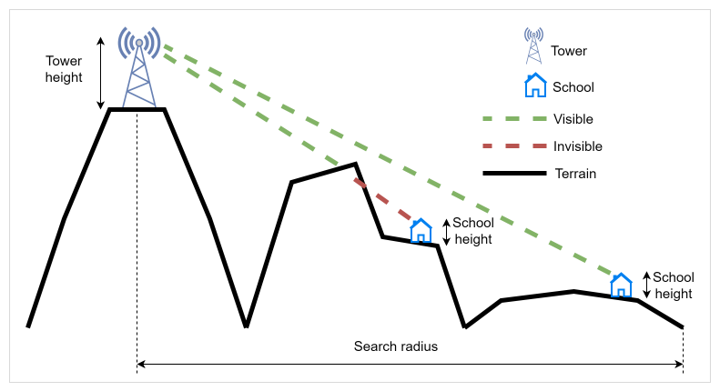
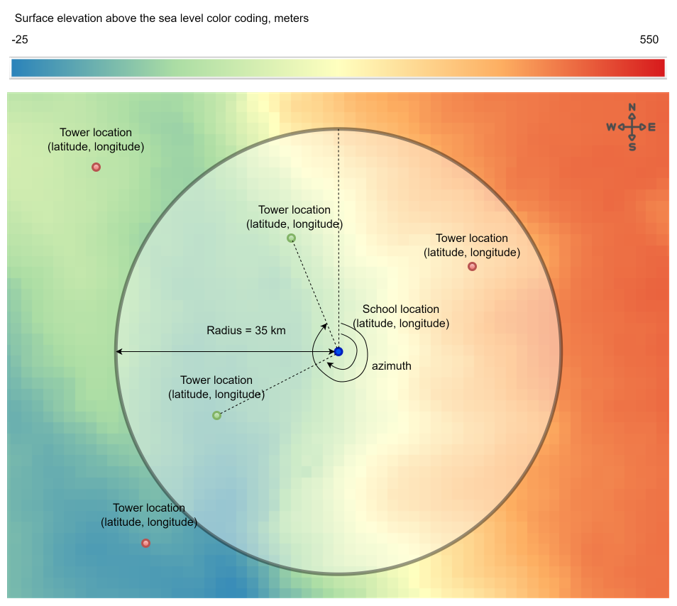

## Download school dataset

#### The data table below contains the following columns:
**source_id** - school unique identifier,<br>
**lat** - geographic latitude,<br>
**lon** - geographic longitude, <br>
**label** - indicate whether a school is connected to the internet or not,<br>
**geometry** - type of geometry that is used to represent a school (POINT) and it's coordinates.<br><br>

In [4]:
algeria_schools = pd.read_csv("https://zstagigaprodeuw1.blob.core.windows.net/gigainframapkit-public-container/algeria/processed/formatted_algeria_schools.csv")

In [5]:
algeria_schools_gdf = gpd.GeoDataFrame(algeria_schools, geometry=gpd.points_from_xy(algeria_schools.lon, algeria_schools.lat), crs='EPSG:4326')

In [6]:
algeria_schools_gdf.head()
# data_table.DataTable(df_school, num_rows_per_page=10)

,poi_id,dataset_id,lat,lon,country_code,poi_type,is_connected,connectivity_type,has_electricity,electricity_type,label,geometry
0,8dd444f0-2eb1-4d9a-bf57-f032e51768e0,34500f3d-aec9-418b-81ff-1a77d23ba047,31.949701,3.580467,DZA,school,False,NaN,NaN,NaN,school,POINT (3.58047 31.94970)
1,a1c86f79-a20e-4001-9ac0-def0831024f1,34500f3d-aec9-418b-81ff-1a77d23ba047,31.976883,3.743190,DZA,school,False,NaN,NaN,NaN,school,POINT (3.74319 31.97688)
2,cb814cd6-0c90-49d6-b847-d163a95e77e0,34500f3d-aec9-418b-81ff-1a77d23ba047,31.950062,3.541530,DZA,school,False,NaN,NaN,NaN,school,POINT (3.54153 31.95006)
3,194188d3-94b1-4e03-a002-25e8c868bfae,34500f3d-aec9-418b-81ff-1a77d23ba047,31.952468,3.529267,DZA,school,False,NaN,NaN,NaN,school,POINT (3.52927 31.95247)
4,c32d3c71-c574-4701-b761-ec757dbe2d4f,34500f3d-aec9-418b-81ff-1a77d23ba047,31.601909,3.676841,DZA,school,False,NaN,NaN,NaN,school,POINT (3.67684 31.60191)


## Download cell site dataset

#### The data table below contains the following columns:
**latitude**	 The geographical latitude of a cellular site <br>
**longitude**	 The geographical longitude of a cellular site <br>
**cell_id**	 A unique identifier for the first cell located at the given latitude and longitude in the dataset <br>
**municipality_code**	 Code corresponding to the level 2 administrative division in Brazil <br>
**technology**	 A list of technologies used at a cellular site <br>
**antenna_height_min**	 The minimum indicated antenna height, in meters, at a given cellular site <br>
**antenna_height_max**	 The maximum indicated antenna height, in meters, at a given cellular site <br>
**validation_date**	 The most recent date on which any cell at a given cellular site was validated<br>
**geometry**	 The geographical location of a cellular site, presented in POINT(lon, lat) format <br><br>


In [7]:
algeria_cellsites = pd.read_csv("https://zstagigaprodeuw1.blob.core.windows.net/gigainframapkit-public-container/algeria/processed/formatted_algeria_cell_sites.csv")

In [8]:
algeria_cellsites_gdf = gpd.GeoDataFrame(algeria_cellsites, geometry=gpd.points_from_xy(algeria_cellsites.lon, algeria_cellsites.lat), crs='EPSG:4326')

In [9]:
algeria_cellsites_gdf.head()
# data_table.DataTable(algeria_cellsites_gdf, num_rows_per_page=10)

,ict_id,dataset_id,lat,lon,radio_type,antenna_height,backhaul_type,backhaul_throughput_mbps,operator_name,azimuth_degrees,tower_height,geometry
0,ffc1a8b1-3f54-4692-9cc7-2249d9fbdbcc,baddd192-284a-4025-8a10-f00929f3456a,36.7380,2.9742,4G,25,NaN,NaN,NaN,NaN,NaN,POINT (2.97420 36.73800)
1,3e8514ad-abc8-4ed0-b80d-01ac43f80bdd,baddd192-284a-4025-8a10-f00929f3456a,36.7447,2.9742,4G,25,NaN,NaN,NaN,NaN,NaN,POINT (2.97420 36.74470)
2,7517a4ca-33b8-4a15-bf03-119dc75f3871,baddd192-284a-4025-8a10-f00929f3456a,36.7453,2.9849,4G,25,NaN,NaN,NaN,NaN,NaN,POINT (2.98490 36.74530)
3,ad795a2c-a08a-46f7-980e-e4fa98a32326,baddd192-284a-4025-8a10-f00929f3456a,36.7491,3.0012,4G,25,NaN,NaN,NaN,NaN,NaN,POINT (3.00120 36.74910)
4,f9599329-bc4a-48ff-9085-deda962262e8,baddd192-284a-4025-8a10-f00929f3456a,36.7503,3.0027,4G,25,NaN,NaN,NaN,NaN,NaN,POINT (3.00270 36.75030)


## Add heights to the school and cell site datasets

In [10]:
algeria_schools_gdf['height'] = school_building_height.value
algeria_cellsites_gdf["antenna_height"] = tower_height.value

## Create KD tree of towers for efficient nearest neighbor search
A KD tree is like a special type of binary tree that organizes points in a space with multiple dimensions. For example, in 2D space, each point has x and y coordinates. In a KD tree, points are arranged in a way that makes it easy to find the nearest neighbors of a given point or find points within a certain range. It does this by splitting the space into smaller regions based on the coordinates of the points. This structure helps reduce the search time and is especially useful in high-dimensional spaces where traditional search methods can be slow.

In [11]:
kdtree = cKDTree(algeria_cellsites_gdf[['lon', 'lat']].values)

## Visibility analysis for one school

### Select one school

In [12]:
sample_school_index = 9569

In [13]:
sample_school_gdf = algeria_schools_gdf.loc[[sample_school_index], :]

### Get neighbour cell sites to the school that are within maximum tower reach distance

In [14]:
def bubble_towers(kdtree_of_towers :cKDTree, query_instance, radius, earth_radius = 6371):
    """
    Finds towers within a specified radius of a query point using a KDTree.

    Args:
        kdtree_of_towers (scipy.spatial.cKDTree): A KDTree of tower coordinates.
        query_instance (numpy.ndarray): The query point.
        radius (float): The radius of the bubble around the query point, in kilometers.

    Returns:
        Tuple: A tuple containing the indices of the towers within the bubble, and their distances from the query point in kilometers.
    """
    # Convert radius from kilometers to degrees.
    radius = radius * np.rad2deg(1/earth_radius)

    # Get the indices of the towers within the specified radius.
    neighbors = kdtree_of_towers.query_ball_point(query_instance, r=radius)

    # Get the distances of the towers within the specified radius from the query point.
    if len(neighbors) > 0:
        dist, ind = kdtree_of_towers.query(query_instance, len(neighbors))
        return ind, np.deg2rad(dist) * earth_radius
    else:
        return None, None

In [15]:
neighbors, dist_km = bubble_towers(kdtree, np.array([sample_school_gdf["lon"].squeeze(), sample_school_gdf["lat"].squeeze()]), max_tower_reach.value)
tower_match = algeria_cellsites_gdf.iloc[neighbors].copy()

In [16]:
tower_match.head()

,ict_id,dataset_id,lat,lon,radio_type,antenna_height,backhaul_type,backhaul_throughput_mbps,operator_name,azimuth_degrees,tower_height,geometry
2022,3991961b-5f7b-4baf-9f4d-4c18edb48f2b,baddd192-284a-4025-8a10-f00929f3456a,35.5681,-0.5225,4G,15.0,NaN,NaN,NaN,NaN,NaN,POINT (-0.52250 35.56810)
2041,8305466d-e3f1-47e1-868f-d8671bc45ca5,baddd192-284a-4025-8a10-f00929f3456a,35.7350,-0.5682,4G,15.0,NaN,NaN,NaN,NaN,NaN,POINT (-0.56820 35.73500)
2042,3737d920-158b-4d4b-9ff5-3e7622e2bf6f,baddd192-284a-4025-8a10-f00929f3456a,35.7350,-0.5683,4G,15.0,NaN,NaN,NaN,NaN,NaN,POINT (-0.56830 35.73500)
2040,fb6820da-076b-4d6b-b28a-791e7e34c7fe,baddd192-284a-4025-8a10-f00929f3456a,35.7358,-0.5685,4G,15.0,NaN,NaN,NaN,NaN,NaN,POINT (-0.56850 35.73580)
2039,4bfeff6a-7749-4888-95c2-3919b20375ec,baddd192-284a-4025-8a10-f00929f3456a,35.7372,-0.5734,4G,15.0,NaN,NaN,NaN,NaN,NaN,POINT (-0.57340 35.73720)


### Plot selected school service area and the towers that are within this area

In [17]:
def plot_locations(school_gdf, school_area, tower_gdf):
    """
    Create an interactive map showing school POI, buffer area, and cell towers.
    
    Parameters:
    -----------
    school_gdf : GeoDataFrame
        Single row GeoDataFrame containing school POI
    school_area : GeoDataFrame
        Single row GeoDataFrame containing school buffer area
    tower_gdf : GeoDataFrame
        GeoDataFrame containing cell tower locations
    """
    # Get center coordinates
    center_lat = school_gdf.geometry.centroid.y.values[0]
    center_lon = school_gdf.geometry.centroid.x.values[0]
    
    # Create base map
    m = folium.Map(location=[center_lat, center_lon], 
                  zoom_start=10)
    
    # Add school buffer area
    folium.GeoJson(
        school_area,
        style_function=lambda x: {
            'fillColor': 'blue',
            'color': 'blue',
            'fillOpacity': 0.2,
            'weight': 1
        }
    ).add_to(m)
    
    # Add school POI
    folium.CircleMarker(
        location=[school_gdf.geometry.centroid.y.values[0], 
                 school_gdf.geometry.centroid.x.values[0]],
        radius=8,
        color='red',
        fill=True,
        popup='School'
    ).add_to(m)
    
    # Add cell towers
    for idx, row in tower_gdf.iterrows():
        folium.CircleMarker(
            location=[row.geometry.y, row.geometry.x],
            radius=6,
            color='green',
            fill=True,
            popup='Cell Tower'
        ).add_to(m)
    
    return m

You can change Maximum Tower Reach (Search radius around schools to look for towers, kilometers) using the slider below. Make sure to press play button to save the changes.

In [18]:
max_tower_reach

FloatSlider(value=35.0, description='Maximum Tower Reach:', layout=Layout(align_items='center', display='flex'…

Execute the following cell to see the figure showing a map with the selected school, cell towers, and round search area. You can change maximum tower reach parameters to see the changes of the search area (press play button to see the changes).

In [19]:
sample_school_area = sample_school_gdf.copy()
sample_school_area["geometry"] = sample_school_gdf["geometry"].buffer(max_tower_reach.value * np.rad2deg(1/6371))
plot_locations(sample_school_gdf, sample_school_area, tower_match)

/var/folders/ww/ybnnslt14m96q4bwh3jfbd5h0000gn/T/ipykernel_68894/3202260238.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sample_school_area["geometry"] = sample_school_gdf["geometry"].buffer(max_tower_reach.value * np.rad2deg(1/6371))
/var/folders/ww/ybnnslt14m96q4bwh3jfbd5h0000gn/T/ipykernel_68894/3143847698.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_lat = school_gdf.geometry.centroid.y.values[0]
/var/folders/ww/ybnnslt14m96q4bwh3jfbd5h0000gn/T/ipykernel_68894/3143847698.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_lon = school_gdf.g

### Check visibility status between the sample school and the first tower

Read elevation data from file (in this example we use SRTM elevation data with 30 meter resolution).

In [20]:
def download_data_files(destination_folder, country_code=None):
    """
    Downloads all SRTM data files for a specified country and saves them to a specified folder.

    Args:
        destination_folder (str): Folder to save files.
        country_code (str, optional): 3-letter ISO country code. If None, downloads all available files.

    Returns:
        None
    """
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    if not country_code:
        raise ValueError("Specify a 'country_code'.")

    base_url = "https://d35k53rhvc9u0d.cloudfront.net/elevation_data/"
    country_path = f"{country_code.upper()}/"
    response = requests.get(f"{base_url}{country_path}index.json")

    if response.status_code != 200:
        raise Exception(f"Failed to retrieve data, status code: {response.status_code}")

    file_list = response.json()['files']

    # Download only files that are not already in the destination folder
    for file in file_list:
        file_name = os.path.basename(file)
        file_path = os.path.join(destination_folder, file_name)
        if not os.path.exists(file_path):
            request.urlretrieve(f"{base_url}{country_path}{file}", file_path)
            print(f"Downloaded {file_name}")
        else:
            print(f"Skipped {file_name}, already exists.")

    print("Download process completed.")

In [21]:
country_code = pycountry.countries.get(name = country.value).alpha_3
print(f"The ISO-3 country code for {country.value} is {country_code}.")

The ISO-3 country code for Algeria is DZA.


In [22]:
download_data_files(
    destination_folder='srtm1',
    country_code=country_code
)

Skipped N18E003.SRTMGL1.hgt.zip, already exists.
Skipped N19E002.SRTMGL1.hgt.zip, already exists.
Skipped N19E003.SRTMGL1.hgt.zip, already exists.
Skipped N19E004.SRTMGL1.hgt.zip, already exists.
Skipped N19E005.SRTMGL1.hgt.zip, already exists.
Skipped N19E006.SRTMGL1.hgt.zip, already exists.
Skipped N20E001.SRTMGL1.hgt.zip, already exists.
Skipped N20E002.SRTMGL1.hgt.zip, already exists.
Skipped N20E003.SRTMGL1.hgt.zip, already exists.
Skipped N20E004.SRTMGL1.hgt.zip, already exists.
Skipped N20E005.SRTMGL1.hgt.zip, already exists.
Skipped N20E006.SRTMGL1.hgt.zip, already exists.
Skipped N20E007.SRTMGL1.hgt.zip, already exists.
Skipped N21E000.SRTMGL1.hgt.zip, already exists.
Skipped N21E001.SRTMGL1.hgt.zip, already exists.
Skipped N21E002.SRTMGL1.hgt.zip, already exists.
Skipped N21E003.SRTMGL1.hgt.zip, already exists.
Skipped N21E004.SRTMGL1.hgt.zip, already exists.
Skipped N21E005.SRTMGL1.hgt.zip, already exists.
Skipped N21E006.SRTMGL1.hgt.zip, already exists.
Skipped N21E007.SRTM

In [23]:
srtm1_data = Srtm1HeightMapCollection(auto_build_index=True, hgt_dir=Path('srtm1'))

To ensure free-space propagation conditions we need to check if a receiver has a clearance above ground of at least 60% of the radius of the first Fresnel zone. [ITU-R P.530-18]
<br>
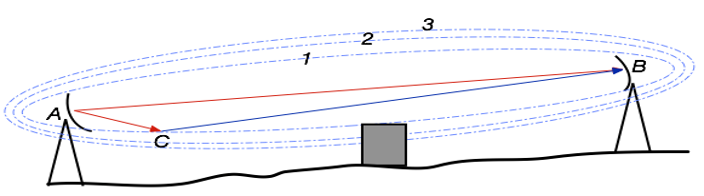
<br>
Picture source: https://en.wikipedia.org/wiki/Fresnel_zone

In [24]:
def calculate_fresnel(x1, y1, x2, y2, frequency, num_points):
    """
    Calculate the shape of the first Fresnel zone for a pair of antennas.

    Parameters:
    x1, y1 : float
        Coordinates of the first antenna in meters.
    x2, y2 : float
        Coordinates of the second antenna in meters.
    frequency : float
        Frequency of the signal in GHz.
    num_points : int
        Number of points to use to approximate the shape of the Fresnel zone.

    Returns:
    x, y : numpy arrays
        x-coordinates and y-coordinates of the points defining the shape of the Fresnel zone.
    """
    # Convert frequency to Hz and set the speed of light in m/s
    fr = frequency * 1e9
    c = 2.997925e8

    # Calculate the wavelength and major/minor axes of the Fresnel zone
    wavelength = c / fr
    a = 0.5 * np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    r = np.sqrt(wavelength * a) / 2

    # Generate N points on the ellipse
    angles = np.linspace(0, 2*np.pi, num_points)
    X = a * np.cos(angles)
    Y = r * np.sin(angles)

    # Rotate and translate the ellipse to align with the line connecting the antennas
    angle = np.arctan2(y2 - y1, x2 - x1)
    x = X * np.cos(angle) - Y * np.sin(angle) + (x1 + x2) / 2
    y = X * np.sin(angle) + Y * np.cos(angle) + (y1 + y2) / 2

    return x, y, r

In [25]:
def check_visibility(srtm1_data: Srtm1HeightMapCollection, lat1, lon1, height1, lat2, lon2, height2, return_data=False):
    """
    Calculates the line-of-sight (LOS) visibility between two points using SRTM data.

    Args:
        srtm1_data (Srtm1HeightMapCollection): Collection of SRTM1 height maps, used to retrieve elevation data along the path.
        lat1 (float): Latitude of the starting point.
        lon1 (float): Longitude of the starting point.
        height1 (float): Height of the starting point above ground level.
        lat2 (float): Latitude of the ending point.
        lon2 (float): Longitude of the ending point.
        height2 (float): Height of the ending point above ground level.
        return_data (bool): If True, returns a DataFrame with detailed line-of-sight data. Default is False.

    Returns:
        bool or DataFrame: True if line of sight exists between the points; False otherwise. 
                           If return_data is True, returns a DataFrame with line-of-sight height, elevation, and distance profiles.
    """

    # Obtain the elevation and distance profiles between the two points
    # The elevation profile provides terrain heights along the path, and distance measures the segment lengths
    e_profile, d_profile = zip(
        *[(i.elevation, i.distance) for i in srtm1_data.get_elevation_profile(lat1, lon1, lat2, lon2)]
    )

    # Handle extreme elevation values by setting values above 65,000 meters (typical for error codes) to below sea level
    e_profile = list(map(lambda x: x - 65535 if x > 65000 else x, e_profile))

    # Calculate line-of-sight profile based on heights at both points
    # The LOS profile linearly interpolates between the heights of the two points along the distance profile
    los_profile = np.linspace(e_profile[0] + height1, e_profile[-1] + height2, len(e_profile))

    # Check if the LOS profile stays above the elevation profile along the entire path
    has_line_of_sight = np.all(los_profile >= e_profile)

    if return_data:
        # If requested, return both the LOS visibility result and a DataFrame with details of each profile point
        return has_line_of_sight, pd.DataFrame(
            zip(los_profile, e_profile, d_profile), columns=['line_of_sight_height', 'elevation', 'distance']
        )

    return has_line_of_sight

##### The data table below contains the following columns:
**index** - the ordered number of digital elevation model pixel along the line of sight starting from school location ending at tower location, <br>
**line of sight height** - the height of a line connecting tower and school antennas above the sea level, meters.<br>
**elevation** - the height of the elevation surface (e.g., ground) along the line of sight line above the sea level, meters.<br>
**distance** - distance from school to the digital elevation model pixel center, meters. <br>

In [26]:
twr = tower_match.iloc[0]

In [27]:
has_line_of_sight, los_data = check_visibility(srtm1_data,
                                               sample_school_gdf["lat"].squeeze(),
                                               sample_school_gdf["lon"].squeeze(),
                                               sample_school_gdf["height"].squeeze(),
                                               twr.lat,
                                               twr.lon,
                                               twr.antenna_height,
                                               return_data = True)

In [28]:
los_data
# data_table.DataTable(los_data, num_rows_per_page=10)

,line_of_sight_height,elevation,distance
0,123.863048,108.863048,8.238496
1,123.826633,110.913459,46.841703
2,123.790218,110.963621,86.531013
3,123.753804,111.013535,126.286574
4,123.717389,112.063200,166.060852
...,...,...,...
408,109.005901,92.060560,16028.191014
409,108.969487,93.010854,16068.001283
410,108.933072,93.960900,16107.811636
411,108.896658,93.910696,16147.622073


### Plot visibility profile for sample school and tower pair

In [29]:
def plot_visibility_profile(srtm1_data, lat1, lon1, height1, lat2, lon2, height2, signal_frequency: float = 2.4):
    """
    Plots the visibility profile between two points, showing elevation, line of sight, and Fresnel zone.

    Args:
        srtm1_data (Srtm1HeightMapCollection): Collection of SRTM1 height maps for elevation data.
        lat1 (float): Latitude of the starting point.
        lon1 (float): Longitude of the starting point.
        height1 (float): Height above ground of the starting point.
        lat2 (float): Latitude of the ending point.
        lon2 (float): Longitude of the ending point.
        height2 (float): Height above ground of the ending point.
        signal_frequency (float): Frequency in GHz to calculate the Fresnel zone radius. Default is 2.4 GHz.

    Returns:
        go.Figure: A Plotly figure showing the visibility profile.
    """

    # Perform visibility check and retrieve DataFrame with elevation profile and distances
    has_line_of_sight, df_elev = check_visibility(
        srtm1_data, lat1, lon1, height1, lat2, lon2, height2, return_data=True
    )

    # Set up the start and end coordinates for plotting
    x_start, x_end = df_elev['distance'].iloc[[0, -1]]
    y_start, y_end = df_elev['elevation'].iloc[[0, -1]]
    min_elevation = df_elev['elevation'].min()  # Minimum elevation to position fill boundaries

    # Calculate Fresnel zone radius along the path
    fresnel_x, fresnel_y, fresnel_r = calculate_fresnel(
        x_start, y_start + height1, x_end, y_end + height2, signal_frequency, len(df_elev)
    )

    # Initialize the Plotly figure
    fig = go.Figure()

    # Add the terrain elevation profile as a line plot
    fig.add_trace(go.Scatter(
        x=df_elev['distance'], y=df_elev['elevation'],
        mode='lines', name='Elevation Profile',
        line=dict(color='#e5e3df', width=2), showlegend=False
    ))

    # Add a fill area below the entire plot for visual context
    fig.add_trace(go.Scatter(
        x=[x_start, x_end], y=[min_elevation - 30, min_elevation - 30],
        mode='lines', name='', line=dict(color='#17BECF', width=0.1),
        fill='tonextx', fillcolor='rgba(229, 227, 223, 0.2)', showlegend=False
    ))

    # Plot the line of sight (LOS) between the two points
    fig.add_trace(go.Scatter(
        x=[x_start, x_end], y=[y_start + height1, y_end + height2],
        mode='lines', name='Line of Sight',
        line=dict(color='#EF553B', width=1)
    ))

    # Indicate the starting point with a vertical line and marker
    fig.add_trace(go.Scatter(
        x=[x_start, x_start], y=[y_start, y_start + height1],
        mode='lines', name='', line=dict(color='#FECB52'), showlegend=False
    ))
    fig.add_trace(go.Scatter(
        x=[x_start], y=[y_start + height1],
        mode='markers', name='Location 1', marker_color='#FECB52'
    ))

    # Indicate the ending point with a vertical line and marker
    fig.add_trace(go.Scatter(
        x=[x_end, x_end], y=[y_end, y_end + height2],
        mode='lines', name='', line=dict(color='#17BECF'), showlegend=False
    ))
    fig.add_trace(go.Scatter(
        x=[x_end], y=[y_end + height2],
        mode='markers', name='Location 2', marker_color='#17BECF'
    ))

    # Plot the Fresnel zone along the path as a dotted line
    fig.add_trace(go.Scatter(
        x=fresnel_x, y=fresnel_y,
        mode='lines', name='Fresnel Zone',
        line=dict(color='#ff9900', width=0.5, dash='dot'), showlegend=True
    ))

    # Customize figure layout for better visibility
    fig.update_layout(
        template='plotly_dark',
        legend=dict(orientation='h'),
        xaxis=dict(showgrid=False, zeroline=False),
        yaxis=dict(showgrid=False, zeroline=False)
    )

    return fig

In [30]:
plot_visibility_profile(srtm1_data,
                        sample_school_gdf["lat"].squeeze(),
                        sample_school_gdf["lon"].squeeze(),
                        sample_school_gdf["height"].squeeze(),
                        twr.lat,
                        twr.lon,
                        twr.antenna_height,
                        signal_frequency = 2.4)

## Visibility analysis for all schools

In [31]:
# Restrict the number of schools to 100 for faster processing
mini_algeria_schools_gdf = algeria_schools_gdf.iloc[:100,:]

In [38]:
# Initialize counter for total visibility checks performed
n_checks = 0

# Create a dictionary to store visibility results for each school
# Keys are school indices, initially set to None
visibility_dict = dict.fromkeys(mini_algeria_schools_gdf.index)

# Iterate through each school in the GeoDataFrame using progress bar
for school in tqdm(mini_algeria_schools_gdf.itertuples()):
    # Initialize entry for current school in visibility dictionary
    # Set default visibility status to False
    visibility_dict.update({
        school.Index: dict(is_visible = False)
    })
    
    # Find all cell towers within maximum reach distance of the school
    # Returns tower indices and their distances from the school
    neighbors, dist_km = bubble_towers(
        kdtree,                          # KD-tree of tower locations
        np.array([school.lon, school.lat]), # School coordinates
        max_tower_reach.value            # Maximum distance to check
    )
    
    # Skip to next school if no towers are within range
    if neighbors is None:
        continue
        
    # Convert single tower index to list format for consistent processing
    # This handles edge case where only one tower is within range
    if isinstance(neighbors, int):
        neighbors = [neighbors]
    
    # Create DataFrame of nearby towers with their distances
    tower_match = algeria_cellsites_gdf.iloc[neighbors].copy()
    tower_match['dist_km'] = dist_km
    
    # Counter for number of visible towers found for current school
    visible_count = 0
    
    # Check line-of-sight visibility for each nearby tower
    for twr in tower_match.itertuples():
        n_checks += 1  # Increment total visibility checks counter
        
        # Perform line-of-sight calculation using terrain data
        has_line_of_sight = check_visibility(
            srtm1_data,          # Terrain elevation data
            school.lat,          # School latitude
            school.lon,          # School longitude
            school.height,       # School height above ground
            twr.lat,            # Tower latitude
            twr.lon,            # Tower longitude
            twr.antenna_height   # Tower height above ground
        )
        
        # Increment counter if tower is visible
        visible_count += has_line_of_sight
        
        # If tower is visible, record its details in the visibility dictionary
        if has_line_of_sight:
            # Create unique key for this visible tower
            twr_idx = 'tower_' + str(visible_count)
            
            # Store tower information
            visibility_dict[school.Index].update({
                twr_idx: twr.Index,                    # Tower's unique identifier
                twr_idx + '_lat': twr.lat,            # Tower's latitude
                twr_idx + '_lon': twr.lon,            # Tower's longitude
                twr_idx + '_dist': twr.dist_km,       # Distance to school in km
                twr_idx + '_los_geom': LineString([   # Line-of-sight geometry
                    twr.geometry, school.geometry
                ])
            })
            
            # Stop checking more towers if we've found desired number of visible towers
            if visible_count == n_visible.value:
                break
    
    # Update school's visibility status (True if at least one tower is visible)
    visibility_dict[school.Index].update(is_visible = visible_count > 0)

# Print summary statistics
print('Visibility check is complete!')
print(f'Average # of checks per school: {n_checks/len(algeria_schools_gdf)}')

100it [00:00, 101.53it/s]

Visibility check is complete!
Average # of checks per school: 0.049873203719357564


In [39]:
df_visibility = pd.DataFrame(visibility_dict.values(), visibility_dict.keys())
df_visibility.head()
# data_table.DataTable(df_visibility, num_rows_per_page=10)

,is_visible,tower_1,tower_1_lat,tower_1_lon,tower_1_dist,tower_1_los_geom,tower_2,tower_2_lat,tower_2_lon,tower_2_dist,tower_2_los_geom,tower_3,tower_3_lat,tower_3_lon,tower_3_dist,tower_3_los_geom
0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/var/folders/ww/ybnnslt14m96q4bwh3jfbd5h0000gn/T/ipykernel_68894/3220554212.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




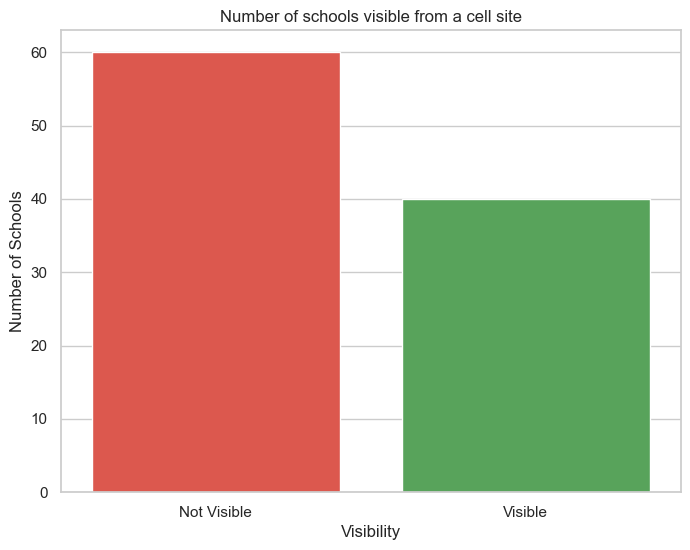

In [41]:
sns.set(style="whitegrid")
visibility_counts = df_visibility["is_visible"].value_counts().rename_axis("Visibility").reset_index(name="Count")
visibility_counts["Visibility"] = visibility_counts["Visibility"].map({True: "Visible", False: "Not Visible"})
plt.figure(figsize=(8, 6))
sns.barplot(x="Visibility", y="Count", data=visibility_counts, palette=["#F44336", "#4CAF50"])
plt.title("Number of schools visible from a cell site")
plt.xlabel("Visibility")
plt.ylabel("Number of Schools")
plt.show()